# author: Danny Petschke
# date:   2021-01-21

* import required modules and connect to the GPU runtime

In [1]:
from __future__ import print_function

import numpy as np, h5py
import matplotlib.pyplot as plt
import random
from joblib import dump, load
import os, time, sys

import tensorflow as tf

from keras.models import Model, Sequential, model_from_json
from keras.layers import BatchNormalization, Convolution2D, Input, SpatialDropout2D, UpSampling2D, UpSampling1D, MaxPooling2D, Multiply, LeakyReLU
from keras.layers import Dense, Dropout, Conv1D, Conv2D, add, Conv3D, Reshape, Activation, Concatenate, AveragePooling1D, LeakyReLU, Flatten
from keras.layers.advanced_activations import PReLU
from keras.callbacks import History, EarlyStopping, ModelCheckpoint, CSVLogger
from keras.optimizers import RMSprop, Adam
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.initializers import RandomNormal

# test for GPU runtime integration
tf.test.gpu_device_name()

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1105935822417801644, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14638920512
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12102191820921730555
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

* mount google drive if necessary



In [ ]:
from google.colab import drive

drive.mount('/content/drive/My Drive')

* define the network architecture

In [2]:
# source of resblock_1D_BN(...): https://github.com/dpscience/DL4FLI

def resblock_1D_BN(num_filters, size_filter, x):
  Fx = Conv1D(num_filters, size_filter, padding='same', activation=None)(x)
  Fx = BatchNormalization()(Fx)
  Fx = Activation('relu')(Fx)
  Fx = Conv1D(num_filters, size_filter, padding='same', activation=None)(Fx)
  Fx = BatchNormalization()(Fx)
  
  output = add([Fx, x])
  output = Activation('relu')(output)

  return output

def create_network(numberOfBins=25,
                   kernel_size=3,
                   strides=1,
                   lr=0.00025):
    init = RandomNormal(stddev=4.2) #'he_uniform'#

    t_data_1  = Input(shape=(numberOfBins, 1)) # A
    t_data_2  = Input(shape=(numberOfBins, 1)) # B
    
    # branch A (= pulse A)
    layer_A=Conv1D(64, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer=init)(t_data_1) 
    layer_A=BatchNormalization()(layer_A)
    layer_A=Activation('relu')(layer_A) # layer_A=PReLU()(layer_A) 
    layer_A=Conv1D(128, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer=init)(layer_A)
    layer_A=BatchNormalization()(layer_A)
    layer_A=Activation('relu')(layer_A) # layer_A=PReLU()(layer_A)
    layer_A=Conv1D(256, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer=init)(layer_A)
    layer_A=Activation('relu')(layer_A) # layer_A=PReLU()(layer_A)
   
    # branch B (= pulse B)
    layer_B=Conv1D(64, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer=init)(t_data_2)
    layer_B=BatchNormalization()(layer_B)
    layer_B=Activation('relu')(layer_B) # layer_B=PReLU()(layer_B) 
    layer_B=Conv1D(128, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer=init)(layer_B)
    layer_B=BatchNormalization()(layer_B)
    layer_B=Activation('relu')(layer_B) # layer_B=PReLU()(layer_B)
    layer_B=Conv1D(256, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer=init)(layer_B)
    layer_B=Activation('relu')(layer_B) # layer_B=PReLU()(layer_B)

    output_1 = Concatenate()([layer_A,layer_B,layer_A])
    output_2 = Concatenate()([layer_B,layer_A,layer_B])

    output = Concatenate()([output_1,output_2])

    output = Flatten()(output)

    output = Reshape(target_shape=(1,output.shape[1]))(output)
    
    # architecture from here according to https://github.com/dpscience/DL4FLI
    output = Conv1D(256, 1, padding='same', activation=None, kernel_initializer=init)(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Conv1D(256, 1, padding='same', activation=None, kernel_initializer=init)(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output) 
    output = resblock_1D_BN(256, 1, output)
    output = resblock_1D_BN(256, 1, output)

    output = Conv1D(128, 1, padding='same', activation=None, kernel_initializer=init)(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Conv1D(64, 1, padding='same', activation=None, kernel_initializer=init)(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    
    output = Flatten()(output)

    output = Dense(1, activation='linear')(output)
    output = Reshape(target_shape=(1,1))(output)

    model = Model(inputs=[t_data_1,t_data_2], outputs=[output]) 

    optimizer = RMSprop(lr=lr)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae']) 

    # print out the model architecture
    model.summary()

    return model

* load the provided dataset and define the fraction of data splitting into training & testing 

In [3]:
# define where your data are stored and where to place the trained model subsequently ...
directory = 'drive/My Drive/deepIRF/'

# template name of the model to be saved during training or to be loaded for testing ...
name_of_model = 'model'

# define the fraction of testing data (this amount is not used during the training process) ...
fraction_for_testing = 0.3 

# load the data ... (X_data_1 = pulse A & X_data_2 = pulse B; Y_data = labels describing the time difference obtained between pulse B - pulse A at a certain CF level) ...
numberOfCells,X_data_1,X_data_2,Y_data = load(directory + 'Co60_data_1024_1000000_pulses.h5') # 1 Mio. pulse-pairs consisting of 1024 sampling points for each pulse

# adjust units from nanoseconds to picoseconds ...
Y_data *= 1000. # ps

# calc. center of mass ... (not necessary at all)
cOfm = np.mean(Y_data)
Y_data -= cOfm

print('center of mass: {0} ps'.format(cOfm))

# normalize data to the overall maximum amplitude ... (provides a better accuracy instead of normalizing each pulse to its amplitude)
max_amp_A = np.amax(X_data_1)
max_amp_B = np.amax(X_data_2)

print('max. amplitude of A: {0}'.format(max_amp_A))
print('max. amplitude of B: {0}'.format(max_amp_B))

X_data_1 /= max_amp_A
X_data_2 /= max_amp_B

center of mass: -1281.6578369140625 ps
max. amplitude of A: 0.27241194248199463
max. amplitude of B: 0.26910778880119324


* may visualize a fraction of loaded pulses ...

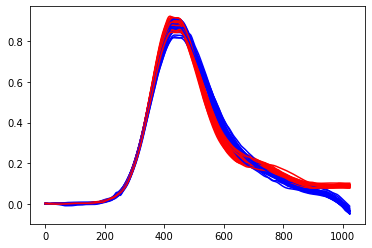

In [8]:
for i in range(25):
  plt.plot(X_data_1[i], 'b-', X_data_2[i], 'r-')

* train the model

In [ ]:
# define the model ...
model = create_network(numberOfBins=numberOfCells, 
                       kernel_size = 11, 
                       strides     = 3, 
                       lr          = 0.0025) # learning rate of the optimizer
    
# setting patience ...
earlyStopping = EarlyStopping(monitor  = 'val_loss', 
                              patience = 25, 
                              verbose  = 0,
                              mode     = 'auto')

# save loss curve (mse) and 'mae' over all trained epochs ...
modelCheckPoint = ModelCheckpoint(filepath       = directory + name_of_model + '.h5', 
                                  monitor        = 'val_loss', 
                                  save_best_only = True, 
                                  verbose        = 0)
    
# train network (65/35 train-to-validation split) ...
history = History()

# number of training data ...
N_train = int((1.-fraction_for_testing)*len(X_data_1))

# log printout ...
csv_logger = CSVLogger(directory + name_of_model +'_log.log')

history = model.fit([X_data_1[:N_train],X_data_2[:N_train]],[Y_data[:N_train]], 
                    validation_split = 0.35,
                    batch_size       = 20, 
                    epochs           = 500, 
                    verbose          = 1, 
                    shuffle          = True, 
                    callbacks        = [earlyStopping,csv_logger,modelCheckPoint])

* test the trained model on independant "unseen" data

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1024, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 342, 64)      768         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 342, 64)      768         input_2[0][0]                    
______________________________________________________________________________________________

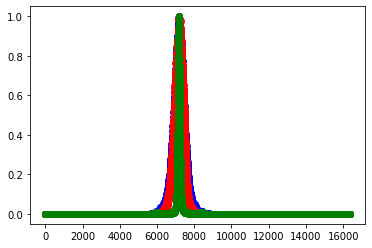

In [9]:
# number of testing data ...
N_test  = int((fraction_for_testing)*len(X_data_1))

# define the model architecture ...
model = create_network(numberOfBins=numberOfCells,
                       kernel_size = 11,
                       strides     = 3,
                       lr          = 0.00025)

# load the weights of the prior trained model ...
model.load_weights(directory + name_of_model + '.h5')

# define number of bins for spectra visualization ...
bins    = 16348                            # should be sufficiently smooth ;)
N       = len(Y_data)                      # N-1 = last index of the loaded data set
start_N = int((1.-fraction_for_testing)*N) # start index for testing data in loaded data set

# determine boundings of the time axis ...
_min_t = np.amin(Y_data[:N])
_max_t = np.amax(Y_data[:N])

# predict uncertainty on ALL data ...
prediction = model.predict([X_data_1,X_data_2]) 

# allocate spectra ...
irf_initial = np.zeros(bins) # spectrum according to the labels using 'Y_data'
irf_pred    = np.zeros(bins) # spectrum according to the predicted values 'prediction'
irf_diff    = np.zeros(bins) # spectrum according to the discrepancy between target and predicted value

# time frame representing the bin ...
d_t = np.abs(_max_t - _min_t)/float(bins-1)

print('bin-width: {0} ps'.format(d_t))

for i in range(start_N,N):
  t = Y_data[i][0]
  index = int((t-_min_t)/d_t)

  if index >= bins or index < 0:
    continue

  irf_initial[index] = irf_initial[index] + 1

  t_diff =  Y_data[i][0] - prediction[i][0][0]

  index = int((t_diff-_min_t)/d_t)

  if index >= bins or index < 0:
    continue

  irf_diff[index] = irf_diff[index] + 1

  t_pred = prediction[i][0][0] 

  index = int((t_pred-_min_t)/d_t)

  if index >= bins or index < 0:
    continue

  irf_pred[index] = irf_pred[index] + 1

# normalize spectra for comparison ...
irf_initial /= sum(irf_initial)
irf_pred    /= sum(irf_pred)
irf_diff    /= sum(irf_diff)

irf_initial /= np.amax(irf_initial)
irf_pred    /= np.amax(irf_pred)
irf_diff    /= np.amax(irf_diff)

plt.plot(irf_initial, 'bo', irf_pred, 'ro', irf_diff, 'go')

# write results to text file ... 
np.savetxt(directory + 'irf_init.txt', irf_initial)
np.savetxt(directory + 'irf_pred.txt', irf_pred)
np.savetxt(directory + 'irf_diff.txt', irf_diff)